In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime, timedelta
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import joblib


In [35]:
# room definition
room_name = "bathroom"

# file name definitions

schedule_file = f"./data/{room_name}/schedule.csv"
schedule_by_time_file = f"./data/{room_name}/schedule_by_time.csv"

data_range_str = "30_01-27_02"

outside_temperature_file = f"./data/{room_name}/outside_temp-{data_range_str}.csv"
inside_temperature_file = f"./data/{room_name}/temp-{data_range_str}.csv"
heating_states_file = f"./data/{room_name}/rad-{data_range_str}.csv"

merged_data_file = f"./data/{room_name}/merged_data.csv"
data_file_for_model = f"./data/{room_name}/data_for_model.csv"

model_file = f"./data/{room_name}/model.joblib"

# data range definition
data_start_time = datetime(2023, 1, 30, 0, 0, 0)
data_end_time = datetime(2023, 2, 27, 0, 0, 0)


In [36]:
# create a heating schedule from csv file that contains 24*7 heating states for each hour of the week starting on monday

# read the schedule csv file
schedule = []

with open(schedule_file, newline="") as csv_file:
    csv_reader = csv.reader(csv_file)

    next(csv_reader)  # skip the header

    for row in csv_reader:
        schedule.append(row[0])

with open(schedule_by_time_file, "w", newline="") as csv_file:
    # Create a CSV writer object
    writer = csv.writer(csv_file)

    # write the header
    writer.writerow(["_time", "_value"])

    current_time = data_start_time  # Initialize current time to start time

    schedule_length = len(schedule)
    is_half_hourly_schedule = schedule_length == 24 * 7 * 2

    while current_time < data_end_time:
        if is_half_hourly_schedule:
            schedule_value = schedule[
                current_time.weekday() * 24 * 2
                + current_time.hour * 2
                + current_time.minute // 30
            ]
        else:
            schedule_value = schedule[current_time.weekday() * 24 + current_time.hour]

        current_time_timezone = current_time - timedelta(hours=2)

        writer.writerow(
            [current_time_timezone.strftime("%Y-%m-%dT%H:%M:%SZ"), schedule_value]
        )

        current_time += timedelta(minutes=1)  # Increment current time by 1 minute


In [37]:
# merge all csv files into one csv file

# read the csv files
df_ot = pd.read_csv(outside_temperature_file)
df_ot = df_ot[["_time", "_value"]]
df_ot.rename(columns={"_value": "outside_temperature"}, inplace=True)

df_it = pd.read_csv(inside_temperature_file)
df_it = df_it[["_time", "_value"]]
df_it.rename(columns={"_value": "inside_temperature"}, inplace=True)

df_hs = pd.read_csv(heating_states_file)
df_hs = df_hs[["_time", "_value"]]
df_hs.rename(columns={"_value": "heating_state"}, inplace=True)

df_sbt = pd.read_csv(schedule_by_time_file)
df_sbt.rename(columns={"_value": "schedule_by_time"}, inplace=True)

# merge the csv files
df = pd.merge(df_ot, df_it, on="_time")
df = pd.merge(df, df_hs, on="_time")
df = pd.merge(df, df_sbt, on="_time")

df["_time"] = pd.to_datetime(df["_time"])

df = df.set_index("_time")

df = df.resample("T").mean()  # resample to 1 minute

# fix for heating state being incorrect
for index, row in df.iterrows():
    prev_index = index - timedelta(minutes=1)
    if (
        row["inside_temperature"] > row["schedule_by_time"]
        and row["heating_state"] == 1
        and df.at[prev_index, "schedule_by_time"] > row["schedule_by_time"]
    ):
        df.at[index, "heating_state"] = 0

df.to_csv(merged_data_file)

df


,outside_temperature,inside_temperature,heating_state,schedule_by_time
_time,,,,
2023-01-29 22:01:00+00:00,4.4,23.85,0.0,16.0
2023-01-29 22:02:00+00:00,4.4,23.85,0.0,16.0
2023-01-29 22:03:00+00:00,4.4,23.85,0.0,16.0
2023-01-29 22:04:00+00:00,4.4,23.85,0.0,16.0
2023-01-29 22:05:00+00:00,4.4,23.85,0.0,16.0
...,...,...,...,...
2023-02-26 21:55:00+00:00,-0.9,22.22,0.0,16.0
2023-02-26 21:56:00+00:00,-0.9,22.22,0.0,16.0
2023-02-26 21:57:00+00:00,-0.9,22.22,0.0,16.0


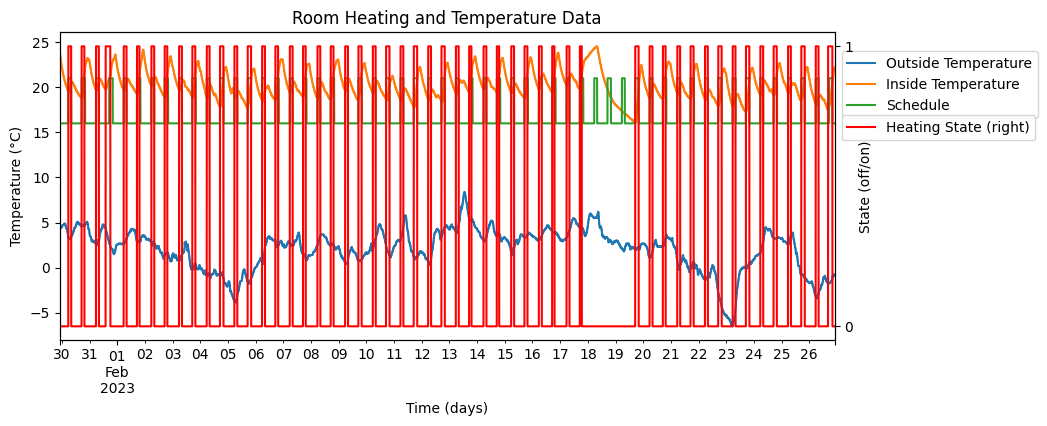

In [38]:
df_modified = df.copy()

# change column names
df_modified = df_modified.rename(
    columns={
        "outside_temperature": "Outside Temperature",
        "inside_temperature": "Inside Temperature",
        "schedule_by_time": "Schedule",
        "heating_state": "Heating State",
    },
)

plot1 = df_modified[["Outside Temperature", "Inside Temperature", "Schedule"]].plot(
    figsize=(10, 4),
    title="Room Heating and Temperature Data",
)

plot2 = df_modified["Heating State"].plot(color="red", secondary_y=True, label="Heating State")

plot1.legend(loc='center left', bbox_to_anchor=(1, 0.83))
plot2.legend(loc='center left', bbox_to_anchor=(1, 0.69))

plot1.set_ylabel("Temperature (°C)")
plot1.set_xlabel("Time (days)")
plot2.set_ylabel("State (off/on)")
plot2.set_yticks([0, 1])


In [39]:
# final data to predict heating time
"""
* start temperature (current inside temperature)
* end temperature (max reached temperature after heating is turned off)
* outside temperature (current outside temperature)
* is radiator hot (has the radiator been turned on for at least 20 minutes in the last 40 minutes)
* heating time (time between start and end temperature) (value to predict)
"""

final_data = pd.DataFrame(
    [],
    columns=[
        "start_temperature",
        "end_temperature",
        "outside_temperature",
        "is_radiator_hot",
        "heating_time",
    ],
)

prev_outside_temperature = 0
prev_inside_temperature = 0
prev_heating_state = 0
prev_schedule_by_time = 0

# # iterate over the data
for index, row in df.iterrows():
    outside_temperature = row["outside_temperature"]
    start_temperature = row["inside_temperature"]
    heating_state = row["heating_state"]
    schedule_by_time = row["schedule_by_time"]

    if (
        prev_outside_temperature == outside_temperature
        and prev_inside_temperature == start_temperature
        and prev_heating_state == heating_state
        and prev_schedule_by_time == schedule_by_time
    ):
        prev_outside_temperature = outside_temperature
        prev_inside_temperature = start_temperature
        prev_heating_state = heating_state
        prev_schedule_by_time = schedule_by_time
        continue  # skip the row if the data is the same as the previous row

    prev_outside_temperature = outside_temperature
    prev_inside_temperature = start_temperature
    prev_heating_state = heating_state
    prev_schedule_by_time = schedule_by_time

    # check if the heating is turned on and collect the data only if it is
    if heating_state == 1:
        next_index = index + timedelta(minutes=1)
        while df.at[next_index, "heating_state"] == 1:
            next_index = next_index + timedelta(minutes=1)

        next_index = next_index - timedelta(minutes=1)

        # next_index is now the index of the last row where the heating is turned on

        end_temperature = df.at[next_index, "inside_temperature"]

        if end_temperature < df.at[next_index, "schedule_by_time"]:
            # if the end temperature is lower than the schedule by time, the heating is turned off before the schedule by time is reached
            continue
        else:
            next_index = next_index + timedelta(minutes=1)
            while df.at[next_index, "inside_temperature"] > end_temperature:
                end_temperature = df.at[next_index, "inside_temperature"]
                next_index = next_index + timedelta(minutes=1)

            # get the heating time
            heating_time = (next_index - index).total_seconds() / 60  # in minutes

        # check if the radiator is hot
        is_radiator_hot = 0
        heating_count = 0
        next_index = index - timedelta(minutes=40)
        while next_index < index:
            if df.at[next_index, "heating_state"] == 1:
                heating_count += 1
            next_index = next_index + timedelta(minutes=1)
        if heating_count >= 20:
            is_radiator_hot = 1

        # add the data to the final data
        final_data = pd.concat(
            [
                final_data,
                pd.DataFrame(
                    {
                        "start_temperature": start_temperature,
                        "end_temperature": end_temperature,
                        "outside_temperature": outside_temperature,
                        "is_radiator_hot": is_radiator_hot,
                        "heating_time": heating_time,
                    },
                    index=[index],
                ),
            ],
        )

final_data.index.name = "_time"

# save the final data to a csv file
final_data.to_csv(data_file_for_model, index=False)


In [40]:
# Describe the heating time data
print(final_data["heating_time"].describe())


count    426.000000
mean      78.107981
std       48.620911
min        1.000000
25%       39.000000
50%       72.000000
75%      111.000000
max      247.000000
Name: heating_time, dtype: float64


In [41]:
# train, test and save the model

X = final_data.drop(["heating_time"], axis=1)
y = final_data["heating_time"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

expected_y = y_test
y_pred = model.predict(X_test)

print(metrics.r2_score(expected_y, y_pred))
print(metrics.mean_squared_error(expected_y, y_pred))
print(np.sqrt(metrics.mean_squared_error(expected_y, y_pred)))

joblib.dump(model, model_file)


0.8957057133482637
208.57741906053852
14.442209632204433


['./data/bathroom/model.joblib']

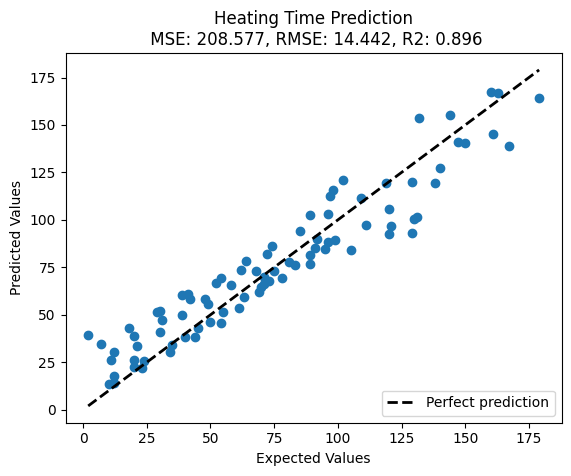

In [42]:
# Visualize the model results
plt.scatter(expected_y, y_pred)
plt.xlabel("Expected Values")
plt.ylabel("Predicted Values")

plt.title(
    "Heating Time Prediction\n MSE: %.3f, RMSE: %.3f, R2: %.3f"
    % (
        metrics.mean_squared_error(expected_y, y_pred),
        np.sqrt(metrics.mean_squared_error(expected_y, y_pred)),
        metrics.r2_score(expected_y, y_pred),
    )
)

(line1,) = plt.plot(
    [expected_y.min(), expected_y.max()],
    [expected_y.min(), expected_y.max()],
    "k--",
    lw=2,
    label="Perfect prediction",
)

plt.legend(handles=[line1], loc="lower right")

plt.show()
